In [1]:
'''
Patrick Ballou
ID: 801130521
ECGR 4106
Homework 1
Problem 2
'''

'\nPatrick Ballou\nID: 801130521\nECGR 4106\nHomework 1\nProblem 2\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler as SS
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
#check if GPU is available and set the device accordingly
#device = 'torch.device("cuda:0" if torch.cuda.is_available() else "cpu")'
device = 'cuda'
print("Using GPU: ", cuda.get_device_name())

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using GPU:  Quadro T2000
Wed Feb  7 02:38:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.23                 Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro T2000                 WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              5W /   30W |    1191MiB /   4096MiB |     21%      Default |
|                                         |                        |                  N/A |
+----------------------

In [4]:
full_df = pd.read_csv('../../Datasets/house-train.csv')

usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
                'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage','WoodDeckSF',
                'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape',
                'LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition', 'SalePrice']

full_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **Problem 1A:**

In [5]:
unscaled_df = full_df[usefull_cols].copy()

unscaled_X = unscaled_df.drop(['SalePrice'], axis=1)
unscaled_X = unscaled_X.apply(pd.to_numeric, errors='coerce').fillna(0)
unscaled_Y = unscaled_df['SalePrice'].values.reshape(-1,1)

X = SS().fit_transform(unscaled_X)
Y = SS().fit_transform(unscaled_Y)

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=7)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train = TensorDataset(x_train, y_train)
val = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=64, shuffle=False)

In [6]:
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))      
        x = self.fc3(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0008)

epochs = 100
training_losses = []
validation_losses = []

In [7]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            pbar.update()
        
        training_losses.append(running_loss / len(train_loader))
        
        model.eval()
        
        running_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
        
        validation_losses.append(running_loss / len(val_loader))
        rmse = np.sqrt(validation_total / len(val_loader.dataset))
        
        pbar.set_postfix({'Training Loss ': training_losses[-1], 'Validation Loss ': validation_losses[-1], 'Validation RMSE ': rmse})

torch.save(model.state_dict(), '../../Models/hw1_2a.pth')

Epoch 1/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 2/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 3/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 4/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 5/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 6/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 7/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 8/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 9/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 10/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 11/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 12/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 13/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 14/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 15/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 16/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 17/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 18/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 19/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 20/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 21/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 22/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 23/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 24/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 25/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 26/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 27/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 28/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 29/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 30/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 31/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 32/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 33/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 34/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 35/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 36/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 37/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 38/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 39/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 40/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 41/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 42/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 43/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 44/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 45/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 46/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 47/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 48/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 49/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 50/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 51/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 52/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 53/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 54/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 55/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 56/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 57/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 58/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 59/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 60/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 61/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 62/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 63/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 64/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 65/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 66/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 67/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 68/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 69/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 70/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 71/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 72/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 73/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 74/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 75/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 76/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 77/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 78/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 79/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 80/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 81/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 82/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 83/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 84/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 85/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 86/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 87/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 88/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 89/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 90/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 91/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 92/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 93/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 94/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 95/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 96/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 97/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 98/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 99/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 100/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Final Training Loss: 3.032738026819731
Final Validation Loss: 8.515102410316468
Final Validation RMSE: 0.3818462356939064


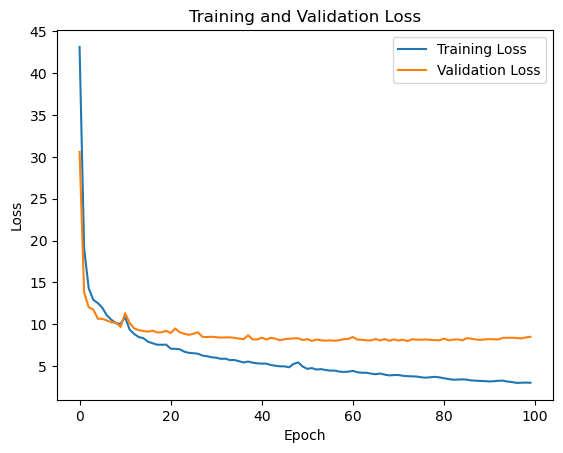

In [8]:
print("Final Training Loss:", training_losses[-1])
print("Final Validation Loss:", validation_losses[-1])
print("Final Validation RMSE:", rmse)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Problem 1B:**

In [9]:
unscaled_df = full_df[usefull_cols].copy()

unencoded_unscaled_X = pd.get_dummies(unscaled_df, columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])
encoded_unscaled_X = unencoded_unscaled_X.replace({True: 1, False: 0})
encoded_unscaled_X = encoded_unscaled_X.apply(pd.to_numeric, errors='coerce').fillna(0)

unscaled_Y = unscaled_df['SalePrice'].values.reshape(-1,1)

X = SS().fit_transform(encoded_unscaled_X)
Y = SS().fit_transform(unscaled_Y)

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=7)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train = TensorDataset(x_train, y_train)
val = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=64, shuffle=False)

C:\Users\patri\AppData\Local\Temp\ipykernel_6912\2007288645.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_unscaled_X = unencoded_unscaled_X.replace({True: 1, False: 0})


In [10]:
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))      
        x = self.fc3(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0008)

epochs = 100
training_losses = []
validation_losses = []

In [11]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            pbar.update()
        
        training_losses.append(running_loss / len(train_loader))
        
        model.eval()
        
        running_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
        
        validation_losses.append(running_loss / len(val_loader))
        rmse = np.sqrt(validation_total / len(val_loader))
        
        pbar.set_postfix({'Training Loss ': training_losses[-1], 'Validation Loss ': validation_losses[-1], 'Validation RMSE ': rmse})

torch.save(model.state_dict(), '../../Models/hw1_2b.pth')

Epoch 1/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 2/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 3/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 4/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 5/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 6/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 7/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 8/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 9/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 10/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 11/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 12/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 13/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 14/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 15/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 16/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 17/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 18/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 19/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 20/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 21/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 22/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 23/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 24/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 25/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 26/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 27/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 28/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 29/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 30/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 31/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 32/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 33/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 34/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 35/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 36/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 37/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 38/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 39/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 40/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 41/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 42/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 43/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 44/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 45/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 46/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 47/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 48/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 49/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 50/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 51/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 52/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 53/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 54/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 55/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 56/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 57/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 58/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 59/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 60/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 61/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 62/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 63/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 64/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 65/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 66/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 67/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 68/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 69/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 70/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 71/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 72/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 73/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 74/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 75/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 76/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 77/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 78/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 79/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 80/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 81/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 82/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 83/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 84/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 85/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 86/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 87/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 88/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 89/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 90/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 91/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 92/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 93/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 94/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 95/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 96/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 97/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 98/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 99/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 100/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Final Training Loss: 0.03129004304738421
Final Validation Loss: 1.0817846432328224
Final Validation RMSE: 1.0400887662804106


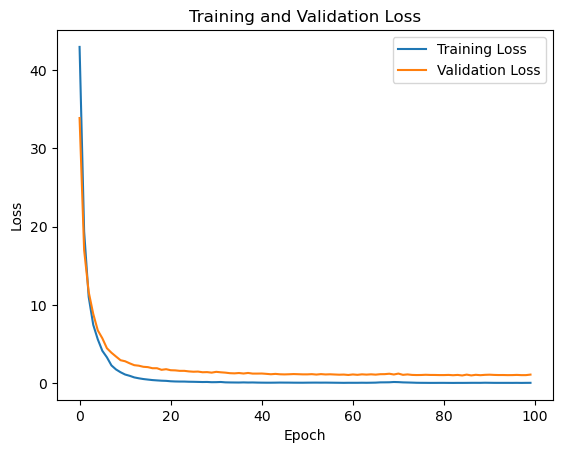

In [12]:
print("Final Training Loss:", training_losses[-1])
print("Final Validation Loss:", validation_losses[-1])
print("Final Validation RMSE:", rmse)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Problem 1C:**

In [13]:
unscaled_df = full_df[usefull_cols].copy()

unencoded_unscaled_X = pd.get_dummies(unscaled_df, columns=['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition'])
encoded_unscaled_X = unencoded_unscaled_X.replace({True: 1, False: 0})
encoded_unscaled_X = encoded_unscaled_X.apply(pd.to_numeric, errors='coerce').fillna(0)

unscaled_Y = unscaled_df['SalePrice'].values.reshape(-1,1)

X = SS().fit_transform(encoded_unscaled_X)
Y = SS().fit_transform(unscaled_Y)

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, random_state=7)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train = TensorDataset(x_train, y_train)
val = TensorDataset(x_val, y_val)

train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=64, shuffle=False)

C:\Users\patri\AppData\Local\Temp\ipykernel_6912\2007288645.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_unscaled_X = unencoded_unscaled_X.replace({True: 1, False: 0})


In [14]:
class RegressNet(nn.Module):
    def __init__(self, input):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(input, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 16)
        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))      
        x = torch.relu(self.fc3(x))      
        x = torch.relu(self.fc4(x))      
        x = self.fc5(x)
        return x

model = RegressNet(input=x_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0008)

epochs = 100
training_losses = []
validation_losses = []

In [15]:
for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit=' batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            pbar.update()
        
        training_losses.append(running_loss / len(train_loader))
        
        model.eval()
        
        running_loss = 0.0
        validation_total = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:            
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                validation_total += ((outputs - labels) ** 2).sum().item()
        
        validation_losses.append(running_loss / len(val_loader))
        rmse = np.sqrt(validation_total / len(val_loader.dataset))
        
        pbar.set_postfix({'Training Loss ': training_losses[-1], 'Validation Loss ': validation_losses[-1], 'Validation RMSE ': rmse})

torch.save(model.state_dict(), '../../Models/hw1_2c.pth')

Epoch 1/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 2/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 3/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 4/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 5/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 6/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 7/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 8/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 9/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 10/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 11/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 12/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 13/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 14/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 15/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 16/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 17/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 18/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 19/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 20/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 21/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 22/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 23/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 24/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 25/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 26/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 27/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 28/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 29/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 30/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 31/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 32/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 33/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 34/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 35/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 36/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 37/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 38/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 39/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 40/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 41/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 42/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 43/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 44/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 45/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 46/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 47/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 48/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 49/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 50/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 51/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 52/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 53/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 54/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 55/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 56/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 57/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 58/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 59/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 60/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 61/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 62/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 63/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 64/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 65/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 66/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 67/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 68/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 69/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 70/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 71/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 72/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 73/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 74/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 75/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 76/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 77/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 78/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 79/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 80/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 81/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 82/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 83/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 84/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 85/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 86/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 87/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 88/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 89/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 90/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 91/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 92/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 93/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 94/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 95/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 96/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 97/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 98/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 99/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Epoch 100/100:   0%|          | 0/19 [00:00<?, ? batch/s]

Final Training Loss: 0.14796865466786058
Final Validation Loss: 0.8522834584116936
Final Validation RMSE: 0.12080519385081238


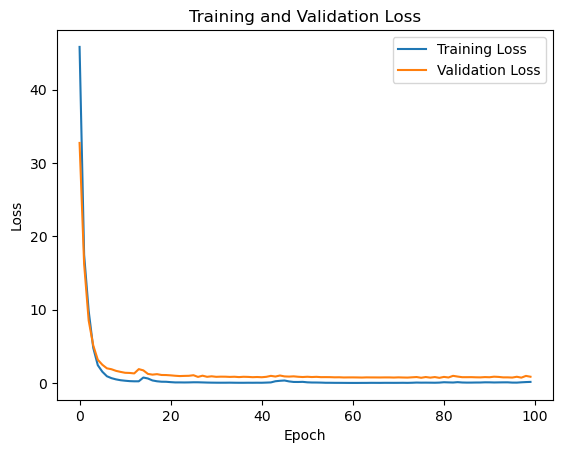

In [16]:
print("Final Training Loss:", training_losses[-1])
print("Final Validation Loss:", validation_losses[-1])
print("Final Validation RMSE:", rmse)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()